In [10]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
# read in all the words
with open('names.txt', 'r') as f:
    words = f.read().splitlines()

words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [12]:
len(words)

32033

In [13]:
# build the vocabulary of characters and mapping to/from integers
characters = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(characters)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(stoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [87]:
# building the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
x, y = [], []
for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        x.append(context)
        y.append(ix)
        #print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix]

x = torch.tensor(x)
y = torch.tensor(y)

In [88]:
x.shape, x.dtype, y.shape, y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [125]:
# Build the dataset
def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
    x, y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            x.append(context)
            y.append(ix)
            #print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]

    x = torch.tensor(x)
    y = torch.tensor(y)
    print(x.shape, y.shape)
    return x, y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
xtr, ytr = build_dataset(words[:n1])
xdev, ydev = build_dataset(words[n1:n2])
xte, yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [89]:
C = torch.randn((27, 2))
C

tensor([[ 0.4810,  0.2461],
        [-0.0413, -2.0559],
        [-0.1618, -1.1112],
        [-0.3515,  0.8033],
        [ 0.4623, -0.1809],
        [ 0.6628, -0.2201],
        [-0.9411, -1.2837],
        [-1.0093,  2.0547],
        [-0.3443, -0.7743],
        [ 0.5992, -1.3176],
        [-0.1715,  1.5271],
        [-0.1260, -0.7498],
        [-2.0975, -0.1596],
        [-0.8652,  1.0362],
        [-0.9843,  1.0344],
        [-0.2228,  0.3630],
        [-0.9647, -0.5340],
        [-0.5199, -1.2349],
        [ 0.1172, -0.7859],
        [ 0.3827,  0.4095],
        [-0.1562,  1.6558],
        [ 1.3401, -1.5164],
        [-0.3353, -0.3131],
        [-0.9004, -0.5602],
        [-0.8400, -0.1791],
        [ 0.6223, -0.0435],
        [-0.7825,  0.4539]])

In [90]:
# The error is intentional to show it doesn't take integers, but takes tensors
F.one_hot(5, num_classes=27)

TypeError: one_hot(): argument 'input' (position 1) must be Tensor, not int

In [91]:
C[5]

tensor([ 0.6628, -0.2201])

In [92]:
emb = C[x]
emb.shape

torch.Size([228146, 3, 2])

In [93]:
W = torch.randn(6, 100)
b1 = torch.randn(100)

In [94]:
# shape mismatch (32, 3, 2) can't be multiplied by (6, 100)
emb @ W + b1

# (32, 3, 2) should be changed to (32, 6)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (684438x2 and 6x100)

In [95]:
# Not generic whatsoever
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1)

tensor([[ 0.4810,  0.2461,  0.4810,  0.2461,  0.4810,  0.2461],
        [ 0.4810,  0.2461,  0.4810,  0.2461,  0.6628, -0.2201],
        [ 0.4810,  0.2461,  0.6628, -0.2201, -0.8652,  1.0362],
        ...,
        [-0.7825,  0.4539, -0.7825,  0.4539,  0.6223, -0.0435],
        [-0.7825,  0.4539,  0.6223, -0.0435, -0.7825,  0.4539],
        [ 0.6223, -0.0435, -0.7825,  0.4539, -0.8400, -0.1791]])

In [96]:
# This one is. Using unbind
torch.cat(torch.unbind(emb, 1), 1).shape

# Like that it doesn't matter how big or small the block size is. However not the most efficient
# Not efficient because it creates a whole new tensor with a whole new storage

torch.Size([228146, 6])

In [97]:
# This is better
emb.view((32, 6))

#and boom, it's identical

RuntimeError: shape '[32, 6]' is invalid for input of size 1368876

In [98]:
h = torch.tanh(emb.view((-1, 6)) @ W + b1)

# the bias vector here is 100. so what tensor does is the following
#32, 100
# 1, 100
# it puts that 100 to the right and does an element wise addition

In [99]:
h

tensor([[-0.5874,  0.0051,  0.8926,  ...,  0.9102,  0.9570,  0.9247],
        [-0.1496, -0.7936,  0.8633,  ...,  0.9580,  0.8515,  0.9377],
        [-0.1064,  0.9943, -0.1340,  ...,  0.9604,  0.9996,  0.7210],
        ...,
        [ 0.6730, -0.9273, -0.3185,  ..., -0.9920, -0.9541,  0.9965],
        [ 0.8901,  0.7937, -0.7555,  ...,  0.0593,  0.9964,  0.9833],
        [ 0.9217, -0.3228, -0.8100,  ...,  0.8609, -0.8421,  0.9735]])

In [100]:
h.shape

torch.Size([228146, 100])

In [101]:
# we're expecting one of 27 letters
W2 = torch.randn(100, 27)
b2 = torch.randn(27)

In [102]:
logits = h @ W2 + b2

In [103]:
logits.shape

torch.Size([228146, 27])

In [104]:
counts = logits.exp()

In [105]:
probs = counts / counts.sum(1, keepdims = True)

In [106]:
probs.shape

torch.Size([228146, 27])

In [107]:
# normalized
probs[0].sum()

tensor(1.0000)

In [108]:
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [109]:
y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [113]:
# The probability assigned to each characher is very small because the NN is not trained yet. and ofc they're idealy 1
probs[torch.arange(32), y[:32]]

tensor([3.0960e-11, 2.0431e-09, 8.4770e-03, 4.0457e-08, 7.6812e-16, 4.2925e-14,
        1.4553e-06, 4.7633e-07, 4.4485e-04, 2.1937e-08, 8.3422e-13, 4.4187e-07,
        2.4433e-13, 4.3137e-10, 1.9612e-07, 3.9856e-07, 8.9888e-04, 1.9046e-04,
        9.8623e-13, 6.7217e-10, 1.9345e-09, 1.0259e-07, 7.4662e-04, 6.2372e-06,
        1.3340e-14, 1.7907e-02, 9.5726e-13, 2.3418e-10, 9.0844e-02, 6.7714e-07,
        1.7016e-07, 1.8321e-06])

In [114]:
loss = -probs[torch.arange(32), y[:32]].log().mean()

In [115]:
loss

tensor(17.4709)

In [116]:
# -------- he said it more respicatable that way ----------

In [131]:
xtr.shape, ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [206]:
g = torch.Generator().manual_seed(2147483674)
C = torch.randn((27, 10), generator=g)
w1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
w2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, w1, b1, w2, b2]

In [207]:
sum(p.nelement() for p in parameters) # counting the number of paramters in the nn in total

11897

In [208]:
for p in parameters:
    p.requires_grad = True

In [209]:
# determining what is a good learning rate for the model
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [210]:
lri = []
lossi = []
stepi = []

In [215]:
for i in range(200000):
    
    # constructing mini batches
    ix = torch.randint(0, xtr.shape[0], (32,))
    
    # Forward pass
    emb = C[xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ w1 + b1) # (32, 100)
    logits = h @ w2 + b2
    
    # counts = h.exp()
    # probs = counts / counts.sum(1, keepdims=True)
    # loss = -probs[torch.arange(32), y].log().mean()      
    
    ## The problem here is that numbers can take a very radical path and getting either too large positive values or very small negative values
    # Large positive values are what makes the problem of overflowing the dtype when introduced to .exp making it a nan (not a number)
    # so what's good about F.cross_entropy is that it subtracts(offsets) the maximum values from the whole vecotr.
    # in practice this is never used for cross entropy doesn't create all these intermediate tensors taking up space

    loss = F.cross_entropy(logits, ytr[ix])
     
    # Now the forward pass is more efficient, the backward pass is more efficient and number are numerically well-behaved 

    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.1
    for p in parameters:
        p.data += -lr * p.grad
    
    stepi.append(i)
        
    # track stats
#     lri.append(lre[i])
    lossi.append(loss.log10().item())
    
print(loss.item())    # In this case the loss is for the mini batch

2.1458206176757812


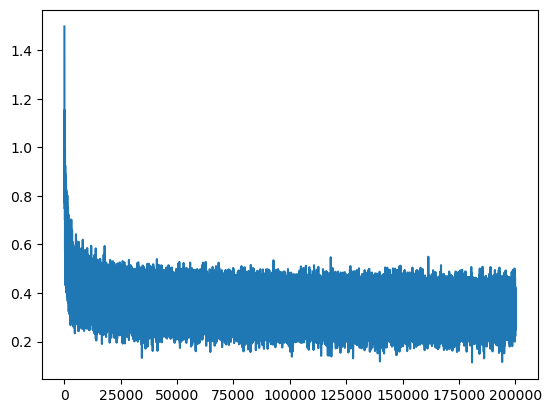

In [212]:
plt.plot(stepi, lossi)

In [ ]:
#plt.plot(lri, lossi)

##### The upper cell takes much time in each iteration because we're working with the whole dataset moving forward and backword. 
##### Instead, a random set of batches (smaller portions of data) are put into forward and backward propagation

### Another note here is that the gradient isn't as stable in the case of mini batches but it's efficient enough

In [216]:
# test loss
emb = C[xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ w1 + b1) # (32, 100)
logits = h @ w2 + b2
loss = F.cross_entropy(logits, ytr)
loss

tensor(2.1700, grad_fn=<NllLossBackward0>)

In [217]:
# dev/validation loss
emb = C[xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ w1 + b1) # (32, 100)
logits = h @ w2 + b2
loss = F.cross_entropy(logits, ydev)
loss

tensor(2.2410, grad_fn=<NllLossBackward0>)

In [142]:
# They're roughly the same i.e. it means we're underfitting
# That typically mean our network is very small

In [124]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

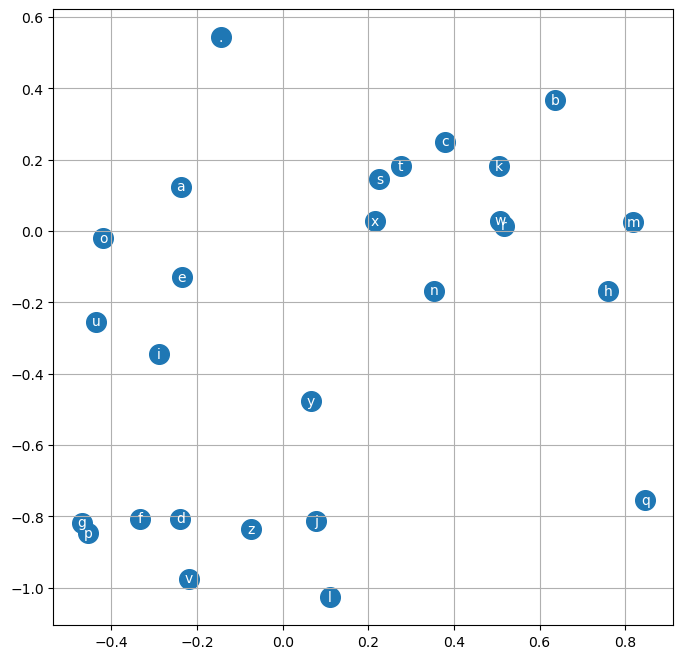

In [177]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [221]:
# sampling from the model
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ w1 + b1)
        logits = h @ w2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

junide.
jaya.
azal.
zyah.
aira.
keitrito.
sami.
ger.
asianasty.
milena.
jededaileti.
safse.
yina.
larke.
faraum.
syi.
demmy.
phnastina.
jaylie.
raaya.
